Ce notebook reprend toute la démarche pour entrainer le modèle final.

# Projet 3A - Classifieurs
### Bilel Ouahmed, Léo Caulier, Mathieu Delattre

## Imports et initialisation

In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import re
from os import listdir
from os.path import isfile, join
from numpy import asarray
import pandas as pd
import random
import os

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
# With Google Colab
from google.colab import drive
drive.mount('drive')

!mkdir -p drive -v

cwd = os.getcwd()

monchemin = 'drive/My Drive/Centrale Marseille/3A/Projet 3A/dataset'

dir_path=os.path.join(cwd, monchemin)
dirs =os.listdir(dir_path)
print(dir_path)
print (dirs)

os.chdir(dir_path)

!export PYTHONPATH=$PYTHONPATH:dir_path

In [2]:
# On local computer
dir_path = "D:/Users/leoca/Documents/Cours/GIT/Projet_3A/"
os.chdir(dir_path)

## Image preprocessing

### Front

In [9]:
foldername_front = os.listdir('data/raw/images_dataset_RVB/images_front')
front_arrays = []

for filename in foldername_front:
  front_arrays.append(img_to_array(load_img(dir_path + 'data/raw/images_dataset_RVB/images_front/' + filename, target_size=(224, 224))))

### Nutrition

In [10]:
foldername_nutrition = os.listdir('data/raw/images_dataset_RVB/images_nutrition')
nutrition_arrays = []

for filename in foldername_nutrition:
  nutrition_arrays.append(img_to_array(load_img(dir_path + 'data/raw/images_dataset_RVB/images_nutrition/' + filename, target_size=(224, 224))))

### Ingredients

In [11]:
foldername_ingredients = os.listdir('data/raw/images_dataset_RVB/images_ingredients')
ingredients_arrays = []

for filename in foldername_ingredients:
    ingredients_arrays.append(img_to_array(load_img(dir_path + 'data/raw/images_dataset_RVB/images_ingredients/' + filename, target_size=(224, 224))))

### Fusion

In [12]:
X = np.concatenate((front_arrays, ingredients_arrays, nutrition_arrays))
y = np.concatenate((np.array([[1, 0, 0]]*len(front_arrays)), np.array([[0, 1, 0]]*len(ingredients_arrays)), np.array([[0, 0, 1]]*len(front_arrays))))
p = np.random.permutation(len(y))

X = X[p]
y = y[p]

In [13]:
# Saving the data to save RAM
with open(dir_path+'data/processed/input_array_224.npy', 'wb') as f:
    np.save(f, X)

with open(dir_path+'data/processed/output_array_224.npy', 'wb') as f:
    np.save(f, y)

## One vs Rest : Front

In [4]:
with open('data/processed/array_entree_224.npy', 'rb') as f:
    X = np.load(f)

with open('data/processed/array_sortie_224.npy', 'rb') as f:
    y = np.load(f)
    
train_proportion = int(0.8*len(X))

X_train = X[:train_proportion]
X_test = X[train_proportion:]
y_train = y[:train_proportion]
y_test = y[train_proportion:]

In [15]:
def plot_learning_curves(history):
    #print history.history.keys()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [40]:
classifier = Sequential()

classifier.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))
classifier.add(Conv2D(256, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))

classifier.add(Conv2D(512, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))
classifier.add(Conv2D(512, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2),strides=2))

classifier.add(Flatten())
classifier.add(Dense(256, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\leoca\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
checkpoint = ModelCheckpoint(dir_path + '/models/callback_checkpoint/model.final', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

h = classifier.fit(X_train, y_train[:, 0], batch_size=32, epochs=10, validation_split=0.1, callbacks=[checkpoint], verbose=1)

Score :  [0.10673404484987259, 0.9607329964637756]


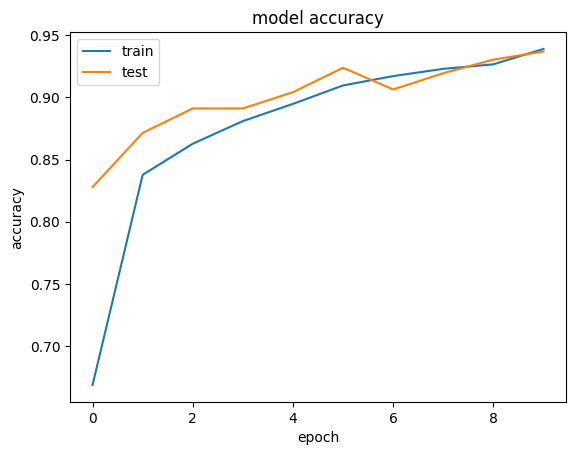

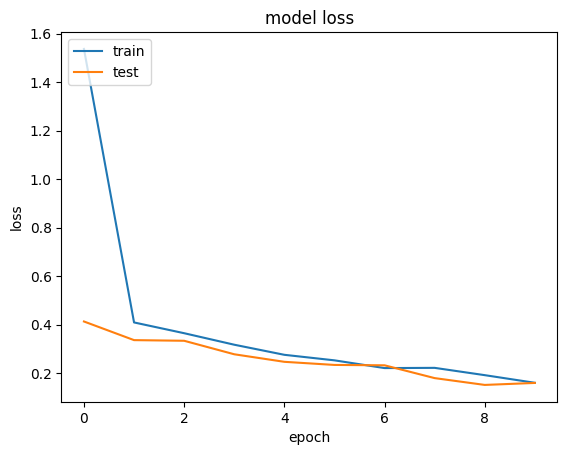

In [31]:
score = classifier.evaluate(X_test, y_test[:, 0], verbose=0)
print("Score : ", score)
plot_learning_curves(h)

In [6]:
classifier.save(dir_path + 'models/models/VGG16_224_32_10_01')

NameError: name 'classifier' is not defined

## Ingrédients vs Nutrition

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [8]:
import torch
import clip

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50x16", device=device)

def ingredients_or_nutrition(img_to_process):

  img = preprocess(Image.fromarray((img_to_process).astype('uint8'))).unsqueeze(0).to(device)
  text = clip.tokenize(["ingredient", "nutritional value"]).to(device)

  with torch.no_grad():
      image_features = model.encode_image(img)
      text_features = model.encode_text(text)
      
      logits_per_image, logits_per_text = model(img, text)
      probs = logits_per_image.softmax(dim=-1).cpu().numpy()
  
  return np.argmax(probs) + 1

## Model Performances

In [7]:
classifier = load_model(dir_path + 'models/models/VGG16_224_32_10_01')

In [ ]:
errors = 0

for i in range(len(X_test)):
  img_to_process = X_test[i]
  is_front = classifier.predict(X_test[i:i+1])
  if is_front < 0.5:
    class_predicted = np.eye(3)[ingredients_or_nutrition(img_to_process)]
  else:
    class_predicted = np.eye(3)[0]
  if (class_predicted == y_test[i]).all():
    pass
  else:
    errors += 1
    print("Erreur rencontrée (" + str(errors) + "/" + str(i) + ") ------- Classe prédite : " + str(class_predicted.astype(int)) + " / Vraie classe : " + str(y_test[i]))

In [33]:
print('Accuracy : ' + str(100*(len(X_test)-errors)/len(X_test)))

Accuracy : 90.05235602094241


In [27]:
y_pred =[]
for i in range(len(X_test)):
  is_front = classifier.predict(X_test[i:i+1])
  if is_front < 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

1/1 [==============================] - 0s 79ms/step


In [32]:
print(y_pred)
print(y_test[:, 0])

[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 

In [34]:
from sklearn.metrics import confusion_matrix
#y_pred = np.argmax (y_pred, axis = 1)
#y_test= np.argmax(y_test[:100], axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test[:, 0], y_pred , normalize='pred')
# 2.4% des fronts ont été prédits comme des ingrédients
print(result)

[[0.98414795 0.0848329 ]
 [0.01585205 0.9151671 ]]


In [55]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [56]:
import tensorflow as tf
import datetime

Accuracy:  0.9607329842931938
Precision:  0.9151670951156813
Recall:  0.967391304347826


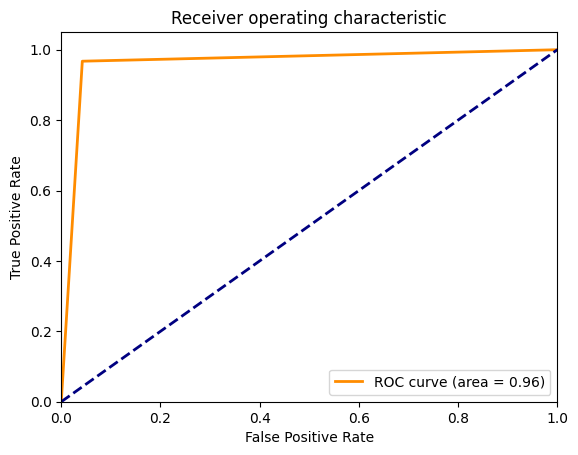

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

# X_test est votre ensemble de données de test et y_test est l'ensemble de labels correspondant
# clf est votre modèle entraîné

# Calcul de la précision, recall et accuracy
accuracy = accuracy_score(y_test[:, 0], y_pred)
precision = precision_score(y_test[:, 0], y_pred)
recall = recall_score(y_test[:, 0], y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

# Calcul de la courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test[:, 0], y_pred)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
